In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from dataset_loader import *
from utils import *
from datasets import Dataset, DatasetDict
import datasets
import logging
import warnings
from retrain_utils import *
logging.disable(logging.WARNING) 
datasets.disable_progress_bar()
warnings.simplefilter("ignore")

SEED = 84
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
dataset_name = 'toy-spam'
ds = get_ds(dataset_name)

In [3]:
model_name =  'huawei-noah/TinyBERT_General_4L_312D'
folder_name = 'tinybert'

In [9]:
retrain_utils = RetrainUtils(model_name, dataset_name, folder_name)
#added_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.ADD)
removed_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REMOVE)
#replaced_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REPLACE)

In [10]:
ds['train'] = removed_train

In [11]:
set_seed()
model = load_model(model_name)
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
_ = train(model, tokenized_data, path=f'{folder_name}/{dataset_name}/check', num_train_epochs=10)
#model.save_pretrained(f'{folder_name}/{dataset_name}/retrained_model')

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.260700,0.900533
2,0.310900,0.255022,0.906933
3,0.310900,0.297877,0.891467
4,0.199100,0.294506,0.906933
5,0.199100,0.331083,0.902667
6,0.146000,0.398241,0.901867
7,0.105100,0.396129,0.898933
8,0.105100,0.422385,0.898133
9,0.076000,0.450906,0.896000
10,0.076000,0.459735,0.896533


In [ ]:
# set_seed()
# model = load_model(model_name)
# tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
# _ = train(model, tokenized_data, path=f'{folder_name}/{dataset_name}/check', num_train_epochs=10, tokens = retrain_utils.get_tokens(20))

In [12]:
model.save_pretrained(f'{folder_name}/{dataset_name}/retrained_model')

### saved best model's folder as 'retrained'

In [13]:
retrained_model = load_model(f'{folder_name}/{dataset_name}/retrained_model').to(device).eval()
orig_model = load_model(f'{folder_name}/{dataset_name}/model').to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
train(orig_model, tokenized_data, path=f'{folder_name}/{dataset_name}', evaluate = True)['eval_accuracy']

0.9130666666666667

# TinyBert

## Spam - domain adaptation

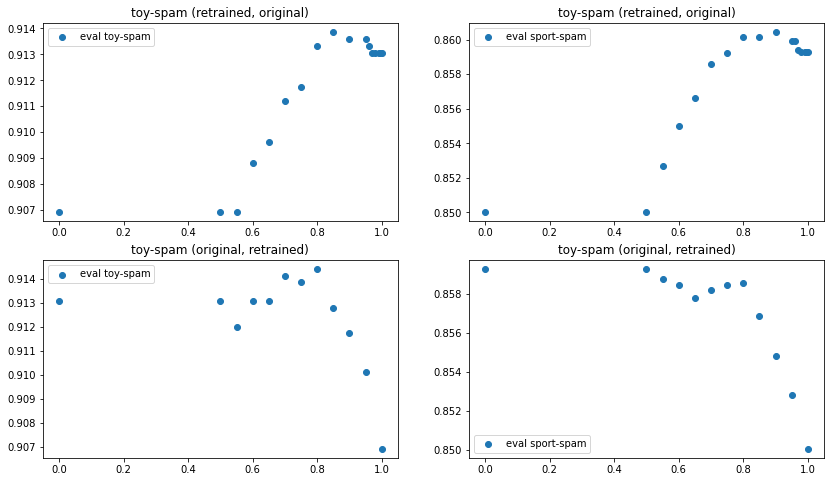

In [17]:
ds = get_ds('toy-spam')
ds_test = get_ds('sport-spam')
ensemble_results(folder_name, model_name, 'toy-spam', 'sport-spam', ds['val'], ds_test['test'], 'retrained_model', 'model')

## Corona

In [29]:
ensemble = Ensemble2(retrained_model, orig_model)
print(f"val: {calc_accuracy(ensemble, ds['val'], tokenizer, False)}")
print(f"test: {calc_accuracy(ensemble, ds['test'], tokenizer, False)}")

val: 0.9258373205741627
test: 0.9235369159623664


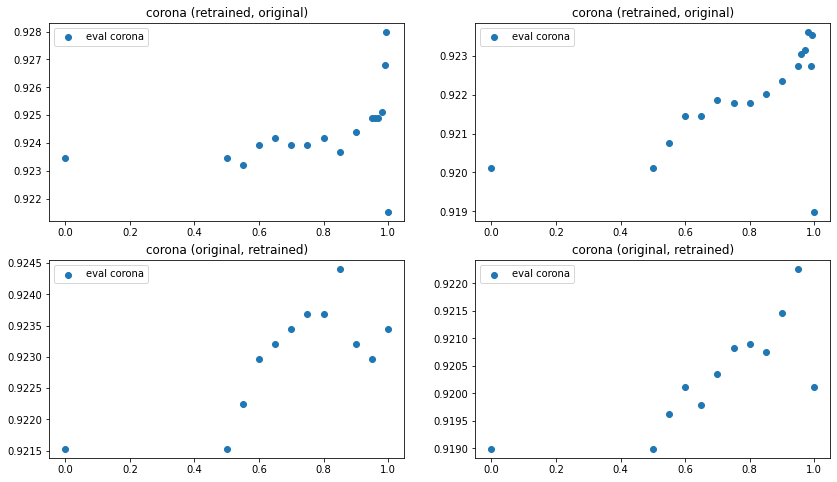

In [5]:
ds = get_ds('corona')
ensemble_results(folder_name, model_name, 'corona', 'corona', ds['val'], ds['test'], 'retrained_model', 'model')

## Sentiment

In [34]:
ensemble = Ensemble2(retrained_model, orig_model)
print(f"val: {calc_accuracy(ensemble, ds['val'], tokenizer, False)}")
print(f"test: {calc_accuracy(ensemble, ds['test'], tokenizer, False)}")

val: 0.8473926380368099
test: 0.8159979555328393


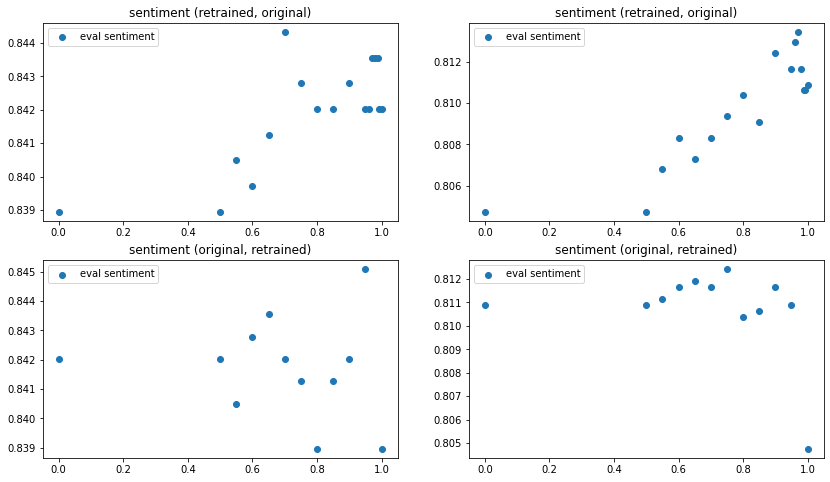

In [9]:
ds = get_ds('sentiment')
ensemble_results(folder_name, model_name, 'sentiment', 'sentiment', ds['val'], ds['test'], 'retrained_model', 'model')

## Dilemma

In [37]:
ensemble = Ensemble2(retrained_model, orig_model)
print(f"val: {calc_accuracy(ensemble, ds['val'], tokenizer, False)}")
print(f"test: {calc_accuracy(ensemble, ds['test'], tokenizer, False)}")

val: 0.90020366598778
test: 0.8969142082061716


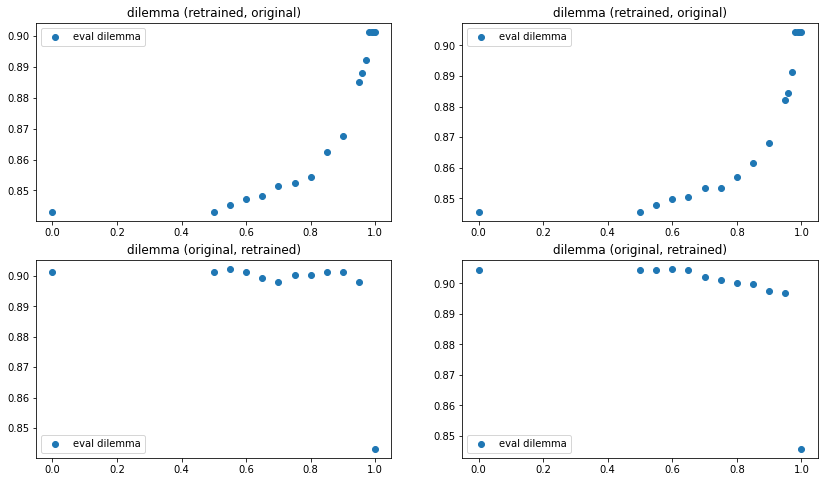

In [5]:
ds = get_ds('dilemma')
ensemble_results(folder_name, model_name, 'dilemma', 'dilemma', ds['val'], ds['test'], 'retrained_model', 'model')

In [13]:
predict_sentences(model, tokenizer, device, [tokenizer.tokenize("i love movies")])

tensor([[ 1.7911, -1.7094]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([0])

In [14]:
predict_sentences(model, tokenizer, device, [tokenizer.tokenize("i hate movies")])

tensor([[-2.3436,  2.2181]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([1])